In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [5]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265, selected_57
from imports import *
from loading import load_session_data
from target import get_spike_counts, build_tgt_matrix, build_silence_matrix
from scipy import stats
from scipy import signal
import pandas as pd
from functools import reduce
from statsmodels.formula.api import ols, glm
from postprocessing.spiketrain import instantaneous_rate

In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## 01 - Syllable ratio matrix

In [7]:
#source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

sessions = selected_57
sessions.sort()
sessions

['57_SIT_2023-12-18_14-07-34',
 '57_SIT_2023-12-22_14-08-07',
 '57_SIT_2023-12-22_14-43-58',
 '57_SIT_2023-12-22_17-37-18',
 '57_SIT_2023-12-23_14-21-01',
 '57_SIT_2023-12-28_16-43-28',
 '57_SIT_2023-12-29_11-06-26',
 '57_SIT_2023-12-29_11-40-14',
 '57_SIT_2023-12-29_12-11-46',
 '57_SIT_2024-01-02_14-43-18',
 '57_SIT_2024-01-02_16-38-05',
 '57_SIT_2024-01-02_17-10-09',
 '57_SIT_2024-01-03_19-22-18',
 '57_SIT_2024-01-03_19-54-59',
 '57_SIT_2024-01-04_14-16-22',
 '57_SIT_2024-01-04_14-52-59',
 '57_SIT_2024-01-05_14-35-49',
 '57_SIT_2024-01-05_15-08-34',
 '57_SIT_2024-01-06_16-52-40',
 '57_SIT_2024-01-06_17-25-35',
 '57_SIT_2024-01-07_19-23-28',
 '57_SIT_2024-01-08_15-51-26',
 '57_SIT_2024-01-12_13-23-02',
 '57_SIT_2024-01-15_13-45-22',
 '57_SIT_2024-01-15_14-34-48']

In [15]:
win_l   = 2    # seconds
step    = 1    # seconds
s_rate  = 100  # Hz
syl_num = 10

for i, session in enumerate(selected_sessions):
    session_data = load_session_data(session, load_aeps=False)
    moseq_file = session_data['moseq_file']
    moseq      = session_data['moseq']
    #animal = session.split('_')[0]
    #moseq_file = os.path.join(source, animal, session, 'moseq.h5')  # can be _full.h5 for dark sessions
    
    # build syllable ratio matrix
    idxs_srm_tl = np.arange(0, len(session_data['tl']), step*s_rate)
    syl_ratio_mx = np.zeros([len(idxs_srm_tl), syl_num])
    for k, idx in enumerate(idxs_srm_tl):
        curr_syls = moseq['syllables reindexed'][idx:idx + win_l*s_rate]
        for j in np.arange(syl_num):
            syl_ratio_mx[k, j] = np.sum(curr_syls == j) / (win_l*s_rate)
    
    # roll 1 sec to match
    syl_ratio_mx = np.roll(syl_ratio_mx, step, axis=0)
    syl_ratio_mx[0] = syl_ratio_mx[1]
    
    with h5py.File(moseq_file, 'a') as f:
        if 'syl_ratio_mx' in f:
            del f['syl_ratio_mx']
        if 'idxs_srm_tl' in f:
            del f['idxs_srm_tl']
        
        id_h5 = f.create_dataset('idxs_srm_tl', data=idxs_srm_tl)
        ds_h5 = f.create_dataset('syl_ratio_mx', data=syl_ratio_mx)
        ds_h5.attrs['win_l']    = win_l
        ds_h5.attrs['step']     = step
        ds_h5.attrs['syl_num']  = syl_num
       
    print("Session %s done" % session)

Session 009265_hippoSIT_2023-02-27_10-18-32 done
Session 009265_hippoSIT_2023-02-27_15-33-46 done
Session 009265_hippoSIT_2023-02-28_09-16-50 done
Session 009265_hippoSIT_2023-02-28_13-16-10 done
Session 009265_hippoSIT_2023-02-28_20-45-04 done
Session 009265_hippoSIT_2023-03-01_10-46-12 done
Session 009265_hippoSIT_2023-03-02_09-32-54 done
Session 009265_hippoSIT_2023-03-02_16-27-42 done
Session 009265_hippoSIT_2023-03-02_20-11-35 done
Session 009265_hippoSIT_2023-03-03_09-37-07 done
Session 009265_hippoSIT_2023-03-03_16-00-47 done
Session 009265_hippoSIT_2023-03-04_11-12-04 done
Session 009265_hippoSIT_2023-03-05_11-52-17 done
Session 009265_hippoSIT_2023-03-05_18-31-32 done
Session 009265_hippoSIT_2023-03-08_18-10-07 done
Session 009265_hippoSIT_2023-03-09_20-03-08 done
Session 009265_hippoSIT_2023-03-10_09-57-34 done
Session 009265_hippoSIT_2023-04-13_09-54-39 done
Session 009265_hippoSIT_2023-04-20_11-39-02 done


[]

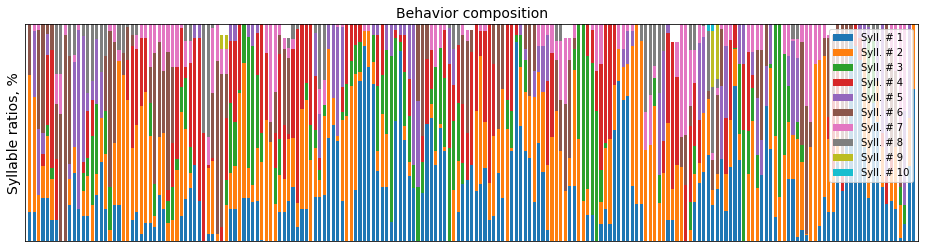

In [9]:
# check syll ratio matrix
session = selected_sessions[0]
session_data = load_session_data(session, load_aeps=False)
tl = session_data['tl']
moseq_file   = session_data['moseq_file']
with h5py.File(moseq_file, 'r') as f:
    syl_ratio_mx  = np.array(f['syl_ratio_mx'])
    idxs_srm_tl   = np.array(f['idxs_srm_tl'])

t1, t2 = 0, 200

#colors_bold = [plt.cm.tab20(2*i) for i in range(10)]
#colors_tran = [plt.cm.tab20(2*i + 1) for i in range(10)]
#colors = colors_bold + colors_tran

fig, ax = plt.subplots(1, 1, figsize=(16, 4))

# syllable ratios
idxs_to_idxs = np.where((tl[idxs_srm_tl][:, 0] > t1) & (tl[idxs_srm_tl][:, 0] < t2))[0]
idxs_sel = idxs_srm_tl[idxs_to_idxs]
bottom = np.zeros(len(idxs_sel))
for i, syl_ratio in enumerate(syl_ratio_mx[idxs_to_idxs].T):
    ax.bar(tl[idxs_sel][:, 0], syl_ratio, 0.7, bottom=bottom, label='Syll. # %s' % str(i+1))
    bottom += syl_ratio
ax.set_xlim(t1, t2)
ax.set_title('Behavior composition', fontsize=14)
ax.set_ylabel('Syllable ratios, %', fontsize=14)
ax.legend(loc='upper right')
ax.set_xticks([])
ax.set_yticks([])

## 02 - Unit corr with shuffled behavior

In [8]:
def get_corr_to_syll_ratios(i_rate_binned, syl_ratio_mx):
    data = np.column_stack([i_rate_binned, syl_ratio_mx])
    columns = ['state'] + ["x%d" % x for x in range(syl_ratio_mx.shape[1])]
    syl_ratio_df = pd.DataFrame(data, columns=columns)

    model = glm('state ~ ' + ' + '.join(columns[1:]), data=syl_ratio_df).fit()

    glm_coeffs = dict([(i, coef) for i, coef in enumerate(model.params[1:]) if model.pvalues[1:][i] < 0.05])
    if len(glm_coeffs) == 0:
        return 0, 0, model.params, model.pvalues
    behav_fit = np.zeros(len(syl_ratio_mx))
    for idx, coef in glm_coeffs.items():
        behav_fit += coef * syl_ratio_mx[:, idx]
        
    corr, pval = stats.pearsonr(behav_fit, i_rate_binned)
    return corr, pval, model.params, model.pvalues

In [13]:
sessions = selected_57
sessions.sort()
selected = sessions[:3]
selected = [
    "57_SIT_2024-01-04_14-16-22",
    "57_SIT_2024-01-04_14-52-59",
]
selected

['57_SIT_2024-01-04_14-16-22', '57_SIT_2024-01-04_14-52-59']

In [19]:
iter_count = 100

for session in selected:
    animal = session.split('_')[0]
    units_file = os.path.join(source, animal, session, 'units.h5')
    moseq_file = os.path.join(source, animal, session, 'analysis', 'MoSeq_tSNE_UMAP.h5')
    moseq_units_glm = os.path.join(source, animal, session, 'analysis', 'MoSeq_units_GLM.h5')
    
    # load syll ratio matrix/tl_idxs
    with h5py.File(moseq_file, 'r') as f:
        syl_ratio_mx  = np.array(f['syl_ratio_mx'])
        idxs_srm_tl   = np.array(f['idxs_srm_tl'])

    # special processing for dark sessions - remove dark
#     if session_data['animal'].startswith('0082'):
#         tl = session_data['tl']
#         idxs_light   = np.where((tl[idxs_srm_tl][:, 0] < 600) | (tl[idxs_srm_tl][:, 0] > 1800))[0]
#         idxs_srm_tl  = idxs_srm_tl[idxs_light]
#         syl_ratio_mx = syl_ratio_mx[idxs_light]

    # load units
    unit_names, single_units, spike_times = [], {}, {}
    with h5py.File(units_file, 'r') as f:
        unit_names = [x for x in f]
    with h5py.File(units_file, 'r') as f:
        for unit_name in unit_names:
            spike_times[unit_name] = np.array(f[unit_name][H5NAMES.spike_times['name']])
            single_units[unit_name] = np.array(f[unit_name][H5NAMES.inst_rate['name']])
            #single_units[unit_name] = instantaneous_rate(unit_times, tl[:, 0], k_width=50)
                
    # create an empty MoSeq units GLM file
    with h5py.File(moseq_units_glm, 'a') as f:
        if not 'units' in f:
            f.create_group('units')

    for name, i_rate in single_units.items():
#         if not name == '1-4':
#             continue        
        
        i_rate_binned = i_rate[idxs_srm_tl]

        # compute original
        corr, pval, params, pvalues = get_corr_to_syll_ratios(i_rate_binned, syl_ratio_mx)

        # compute shuffled
        corr_mx = np.zeros([iter_count, 2])  # coeff, pval for each shuffle
        for i in range(iter_count):
            srm = syl_ratio_mx.copy()
            np.random.shuffle(srm)
            corr_s, pval_s, _, _ = get_corr_to_syll_ratios(i_rate_binned, srm)
            corr_mx[i] = (corr_s, pval_s)
            del srm

        with h5py.File(moseq_units_glm, 'a') as f:
            if not name in f['units']:
                f['units'].create_group(name)
            unit_grp = f['units'][name]

            if 'corr_glm_fit_orig' in unit_grp:
                del unit_grp['corr_glm_fit_orig']
            if 'corr_glm_fit_shuffled' in unit_grp:
                del unit_grp['corr_glm_fit_shuffled']
            if 'glm_fit_params' in unit_grp:
                del unit_grp['glm_fit_params']
            if 'glm_fit_pvalues' in unit_grp:
                del unit_grp['glm_fit_pvalues']

            unit_grp.create_dataset('corr_glm_fit_orig', data=np.array([corr, pval]))
            unit_grp.create_dataset('corr_glm_fit_shuffled', data=corr_mx)
            unit_grp.create_dataset('glm_fit_params', data=params)
            unit_grp.create_dataset('glm_fit_pvalues', data=pvalues)

        print(name + '; ', end='')
        
    print('Session %s done' % session)

1-10; 1-11; 1-12; 1-13; 1-14; 1-15; 1-16; 1-17; 1-18; 1-19; 1-2; 1-3; 1-4; 1-5; 1-6; 1-7; 1-8; 1-9; 2-10; 2-11; 2-12; 2-13; 2-14; 2-15; 2-16; 2-17; 2-2; 2-3; 2-4; 2-5; 2-6; 2-7; 2-8; 2-9; Session 57_SIT_2024-01-04_14-16-22 done
1-10; 1-11; 1-12; 1-13; 1-14; 1-15; 1-2; 1-3; 1-4; 1-5; 1-6; 1-7; 1-8; 1-9; 2-10; 2-11; 2-2; 2-3; 2-4; 2-5; 2-6; 2-7; 2-8; 2-9; Session 57_SIT_2024-01-04_14-52-59 done


## 03 - Unit / GLM predictions for train / split

In [20]:
iter_count = 100

for session in selected:
    animal = session.split('_')[0]
    units_file = os.path.join(source, animal, session, 'units.h5')
    moseq_file = os.path.join(source, animal, session, 'analysis', 'MoSeq_tSNE_UMAP.h5')
    moseq_units_glm = os.path.join(source, animal, session, 'analysis', 'MoSeq_units_GLM.h5')
    
    # load syll ratio matrix/tl_idxs
    with h5py.File(moseq_file, 'r') as f:
        syl_ratio_mx  = np.array(f['syl_ratio_mx'])
        idxs_srm_tl   = np.array(f['idxs_srm_tl'])

    # load units
    unit_names, single_units, spike_times = [], {}, {}
    with h5py.File(units_file, 'r') as f:
        unit_names = [x for x in f]
    with h5py.File(units_file, 'r') as f:
        for unit_name in unit_names:
            spike_times[unit_name] = np.array(f[unit_name][H5NAMES.spike_times['name']])
            single_units[unit_name] = np.array(f[unit_name][H5NAMES.inst_rate['name']])
            #single_units[unit_name] = instantaneous_rate(unit_times, tl[:, 0], k_width=50)
        
    # second do train GLM on 50/50% of chunk-shuffled data
    chunk_size  = 5  # seconds, syll_ratio_mx is sampled 4 Hz
    chunk_count = int(len(syl_ratio_mx)/chunk_size)
    split_ratio = 0.5

    for name, i_rate in single_units.items():
#         if not name == '6-3':
#             continue
        
        i_rate_binned = i_rate[idxs_srm_tl]

        # split into chunks
        syll_chunks   = np.array(np.array_split(syl_ratio_mx[:chunk_count*chunk_size], chunk_count))
        i_rate_chunks = np.array(np.array_split(i_rate_binned[:chunk_count*chunk_size], chunk_count))

        # compute chunked
        corr_tr_mx = np.zeros([iter_count, 2])  # coeff, pval for each random chunking
        glm_cf_mx = np.zeros([iter_count, syl_ratio_mx.shape[1] + 1])  # + intercept  !!
        glm_pv_mx = np.zeros([iter_count, syl_ratio_mx.shape[1] + 1])  # + intercept  !!
        for i in range(iter_count):
            # random indices
            idxs_ch_rand = np.random.choice(np.arange(chunk_count).astype(np.int32), chunk_count, replace=False)

            # randomized behav / unit firing
            i_rate_rand = i_rate_chunks[idxs_ch_rand].flatten()
            syll_chunks_rand = syll_chunks[idxs_ch_rand]
            syll_chunks_rand = syll_chunks_rand.reshape(-1, syll_chunks_rand.shape[-1])

            # build train, split
            idx_split = int(split_ratio*len(syll_chunks_rand))
            data = np.column_stack([i_rate_rand[:idx_split], syll_chunks_rand[:idx_split]])
            columns = ['state'] + ["x%d" % x for x in range(syll_chunks_rand.shape[1])]
            syl_ratio_df = pd.DataFrame(data, columns=columns)

            if (syl_ratio_df['state'] == 0).all():
                continue

            model = glm('state ~ ' + ' + '.join(columns[1:]), data=syl_ratio_df).fit()

            glm_cf_mx[i] = model.params
            glm_pv_mx[i] = model.pvalues

            glm_coeffs = dict([(i, coef) for i, coef in enumerate(model.params[1:]) if model.pvalues[1:][i] < 0.95])
            if not len(glm_coeffs) == 0:
                behav_fit = np.zeros(len(syll_chunks_rand[-idx_split:]))
                for idx, coef in glm_coeffs.items():
                    behav_fit += coef * syll_chunks_rand[-idx_split:][:, idx]
                if not (np.diff(behav_fit) == 0).all():
                    corr_tr_mx[i] = stats.pearsonr(behav_fit, i_rate_rand[-idx_split:])

        with h5py.File(moseq_units_glm, 'a') as f:
            if not 'units' in f:
                f.create_group('units')
            if not name in f['units']:
                f['units'].create_group(name)
            unit_grp = f['units'][name]

            if 'corr_glm_fit_train_test' in unit_grp:
                del unit_grp['corr_glm_fit_train_test']
            if 'glm_cf_mx' in unit_grp:
                del unit_grp['glm_cf_mx']
            if 'glm_pv_mx' in unit_grp:
                del unit_grp['glm_pv_mx']

            unit_grp.create_dataset('corr_glm_fit_train_test', data=corr_tr_mx)
            unit_grp.create_dataset('glm_cf_mx', data=glm_cf_mx)
            unit_grp.create_dataset('glm_pv_mx', data=glm_pv_mx)
        print(name + '; ', end='')
    
    print('Session %s done' % session)

1-10; 1-11; 1-12; 1-13; 1-14; 1-15; 1-16; 1-17; 1-18; 1-19; 1-2; 1-3; 1-4; 1-5; 1-6; 1-7; 1-8; 1-9; 2-10; 2-11; 2-12; 2-13; 2-14; 2-15; 2-16; 2-17; 2-2; 2-3; 2-4; 2-5; 2-6; 2-7; 2-8; 2-9; Session 57_SIT_2024-01-04_14-16-22 done
1-10; 1-11; 1-12; 1-13; 1-14; 1-15; 1-2; 1-3; 1-4; 1-5; 1-6; 1-7; 1-8; 1-9; 2-10; 2-11; 2-2; 2-3; 2-4; 2-5; 2-6; 2-7; 2-8; 2-9; Session 57_SIT_2024-01-04_14-52-59 done


## Test - shuffled VS original syll ratios

In [58]:
unit = '6-3'

session = list(selected_009265.keys())[10]

session_data = load_session_data(session, load_aeps=False)
moseq_file = session_data['moseq_file']

with h5py.File(moseq_file, 'r') as f:
    grp = f['units'][unit]
    corr_glm_fit_orig       = np.array(grp['corr_glm_fit_orig'])
    corr_glm_fit_shuffled   = np.array(grp['corr_glm_fit_shuffled'])
    corr_glm_fit_train_test = np.array(grp['corr_glm_fit_train_test'])

Text(0.5, 1.0, 'Unit 6-3 (0.42)')

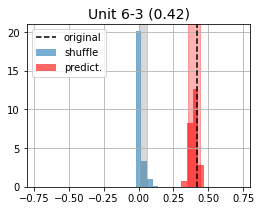

In [59]:
fig, ax = plt.subplots(1,1, figsize=(4, 3))

coeffs_shuf = corr_glm_fit_shuffled[corr_glm_fit_shuffled[:, 1] < 0.95][:, 0]
coeffs_chun = corr_glm_fit_train_test[corr_glm_fit_train_test[:, 1] < 0.95][:, 0]
bins = np.linspace(-1, 1, 50)

ax.hist(coeffs_shuf, bins=bins, alpha=0.6, density=True, label='shuffle', color='tab:blue')
ax.hist(coeffs_chun, bins=bins, alpha=0.6, density=True, label='predict.', color='red')
ax.axvspan(np.percentile(coeffs_shuf, 5), np.percentile(coeffs_shuf, 95), alpha=0.3, color='gray')
ax.axvspan(np.percentile(coeffs_chun, 5), np.percentile(coeffs_chun, 95), alpha=0.3, color='red')
ax.axvline(corr_glm_fit_orig[0], color='black', ls='--', label='original')
ax.set_xlim(-0.8, 0.8)
ax.grid()
ax.legend(loc='upper left')
ax.set_title('Unit %s (%.2f)' % (unit, corr_glm_fit_orig[0]), fontsize=14)